# Dog&Cat Images Classification and Model Deployment (TensorFlow & Keras & GPU)

In [1]:
# !pip install --upgrade pip
# !pip install tensorflow==2.2.3
# !pip install tensorflow_datasets
# !pip install tensorflow_hub

In [2]:
# inport packages
import os
import numpy as np
import glob
import shutil

import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_hub as hub

import tensorflow.keras as keras 
import tensorflow.keras.layers as layers
from tensorflow.keras import layers
# import tensorflowjs as tfjs

import matplotlib.pyplot as plt

In [3]:
# Tensorflow version
tf.__version__

'2.2.3'

In [4]:
tf.test.gpu_device_name()

'/device:GPU:0'

In [5]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

In [26]:
# check how many GPU
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [7]:
#import ImageDataGenerator packages
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [8]:
# dataset setattr
setattr(tfds.image_classification.cats_vs_dogs, '_URL',"https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip")

In [9]:
# download data and splits train & test data
splits = [ 'train[:70%]', 'train[70%:]']

(training_set, validation_set), dataset_info = tfds.load('cats_vs_dogs', with_info=True, as_supervised=True, split=splits)

In [10]:
# Check data
num_classes = dataset_info.features['label'].num_classes
num_training_examples = 0
num_validation_examples = 0

for _ in training_set:
    num_training_examples +=1

for _ in validation_set:
    num_validation_examples +=1
    
print('Total Number of Classes: {}'.format(num_classes))
print('Total Number of Training Images: {}'.format(num_training_examples))
print('Total Number of Validation Images: {} \n'.format(num_validation_examples))

for i, example in enumerate(training_set.take(5)):
  print('Image {} shape: {} label: {}'.format(i+1, example[0].shape, example[1]))

Total Number of Classes: 2
Total Number of Training Images: 16283
Total Number of Validation Images: 6979 

Image 1 shape: (262, 350, 3) label: 1
Image 2 shape: (409, 336, 3) label: 1
Image 3 shape: (493, 500, 3) label: 1
Image 4 shape: (375, 500, 3) label: 0
Image 5 shape: (240, 320, 3) label: 1


In [12]:
# set image resolution & batch_size
IMAGE_RES = 150

def format_image(image, label):
    image = tf.image.resize(image, (IMAGE_RES, IMAGE_RES))/255.0

    return image, label

batch_size = 32

train_batches = training_set.shuffle(num_training_examples//4).map(format_image).batch(batch_size).prefetch(1)

validation_batches = validation_set.map(format_image).batch(batch_size).prefetch(1)

In [13]:
# URL = 'https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4'
# feature_extractor = hub.KerasLayer(URL, input_shape=(IMAGE_RES, IMAGE_RES, 3))
# set feature --> False --> learn better
# feature_extractor.trainable = False

In [14]:
# create keras model
model = keras.Sequential([
    keras.layers.Conv2D(16, (3, 3), activation='relu', input_shape=(IMAGE_RES, IMAGE_RES, 3)),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Conv2D(32, (3, 3), activation='relu'),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Conv2D(64, (3, 3), activation='relu'),
    keras.layers.MaxPooling2D((2, 2)),
    # keras.layers.Dropout(0.2),
    keras.layers.Flatten(),
    keras.layers.Dense(512, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')
])

In [15]:
#model compile, metrics --> accuracy
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [16]:
# Model summary
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 18496)             0

In [17]:
# Train the Model
epochs = 10

with tf.device('GPU:0'):

    history = model.fit(train_batches, epochs=epochs, validation_data=validation_batches)

Epoch 1/10
509/509 [==============================] - 14s 27ms/step - loss: 0.6072 - accuracy: 0.6691 - val_loss: 0.5178 - val_accuracy: 0.7504
Epoch 2/10
509/509 [==============================] - 14s 27ms/step - loss: 0.4749 - accuracy: 0.7703 - val_loss: 0.4580 - val_accuracy: 0.7901
Epoch 3/10
509/509 [==============================] - 14s 27ms/step - loss: 0.3890 - accuracy: 0.8255 - val_loss: 0.4369 - val_accuracy: 0.7994
Epoch 4/10
509/509 [==============================] - 14s 27ms/step - loss: 0.3121 - accuracy: 0.8637 - val_loss: 0.4315 - val_accuracy: 0.8109
Epoch 5/10
509/509 [==============================] - 14s 27ms/step - loss: 0.2137 - accuracy: 0.9097 - val_loss: 0.5193 - val_accuracy: 0.8116
Epoch 6/10
509/509 [==============================] - 14s 27ms/step - loss: 0.1139 - accuracy: 0.9568 - val_loss: 0.6338 - val_accuracy: 0.8114
Epoch 7/10
509/509 [==============================] - 14s 27ms/step - loss: 0.0690 - accuracy: 0.9742 - val_loss: 0.7462 - val_accuracy:

In [18]:
# Check history keys
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [19]:
# Average values
print("Average train loss: ", np.average(history.history['loss']))
print("Average train accuracy: ", np.average(history.history['accuracy']))
print("Average train val_loss: ", np.average(history.history['val_loss']))
print("Average train val_accuracy: ", np.average(history.history['val_accuracy']))

Average train loss:  0.2269574522972107
Average train accuracy:  0.893889331817627
Average train val_loss:  0.6723202705383301
Average train val_accuracy:  0.7999283671379089


# Plot

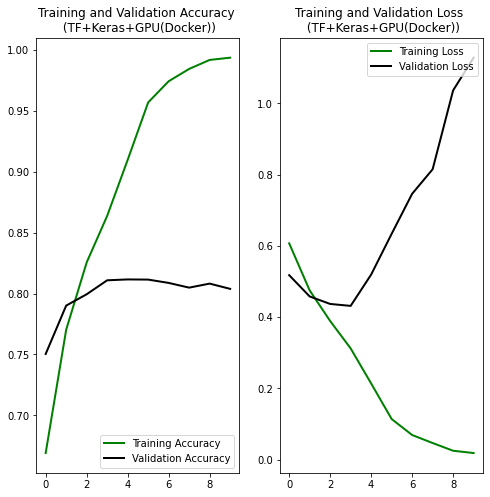

In [20]:
# Plot Training and Validation Graphs one gpu.
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy', linewidth=2, color="green")
plt.plot(epochs_range, val_acc, label='Validation Accuracy', linewidth=2, color="black")
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy \n (TF+Keras+GPU(Docker))')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss', linewidth=2, color="green")
plt.plot(epochs_range, val_loss, label='Validation Loss', linewidth=2, color="black")
plt.legend(loc='upper right')
plt.title('Training and Validation Loss \n (TF+Keras+GPU(Docker))')
plt.show()

In [21]:
model.save('models/GPU_model.h5')

## Model Deployment

In [22]:
export_path = 'models/GPU_model.h5'

In [23]:
reload_sm_keras = tf.keras.models.load_model(
  export_path,
  custom_objects={'KerasLayer': hub.KerasLayer})

reload_sm_keras.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 18496)             0

In [24]:
result_batch = model.predict(train_batches)

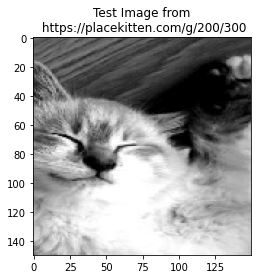

This image most likely belongs to cat with a 73.11 percent confidence.


In [25]:
#Model Deployment
#Using a random cat picture found in the web
picture_url = "https://placekitten.com/g/200/300"
picture_path = tf.keras.utils.get_file("300", origin=picture_url)

img = keras.preprocessing.image.load_img(picture_path, target_size=(IMAGE_RES, IMAGE_RES))

img_array = keras.preprocessing.image.img_to_array(img)
#show image
from matplotlib import pyplot as plt
from matplotlib import image as mpimg
 
plt.title("Test Image from\n " + picture_url)
plt.imshow(img)
plt.show()
img_array = tf.expand_dims(img_array, 0) # Make a batch

predictions = reload_sm_keras.predict(img_array)
score = tf.nn.sigmoid(predictions[0])
classes = ['cat','dog']
print("This image most likely belongs to {} with a {:.2f} percent confidence.".format(classes[np.argmax(score)], 100 * np.max(score)))